In [11]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf-nightly-gpu-2.0-preview: filename=tf_nightly_gpu_2_0_preview-0.0.0.1-py3-none-any.whl size=1542 sha256=ad785b9c5b52c4504848291245f769cd9d417aae664ca909a58c70fb5a1151b5
  Stored in directory: /root/.cache/pip/wheels/89/c6/2e/5b35865ca6234c39a564b7803e8105a8050cb66121a475b27c
Successfully built tf-nightly-gpu-2.0-preview


In [3]:
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os

dataset_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train"

# Check if the path exists
if os.path.exists(dataset_path):
    print("Dataset found!")
else:
    print("Dataset not found!")

Dataset found!


# **vgg16 model**

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
# Ensure TensorFlow is using GPU

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and being used.")
else:
    print("❌ No GPU found. Check Kaggle settings.")

✅ GPU is available and being used.


Class Distribution Before Oversampling:
DRUSEN: 8616 images
CNV: 37205 images
NORMAL: 51140 images
DME: 11348 images


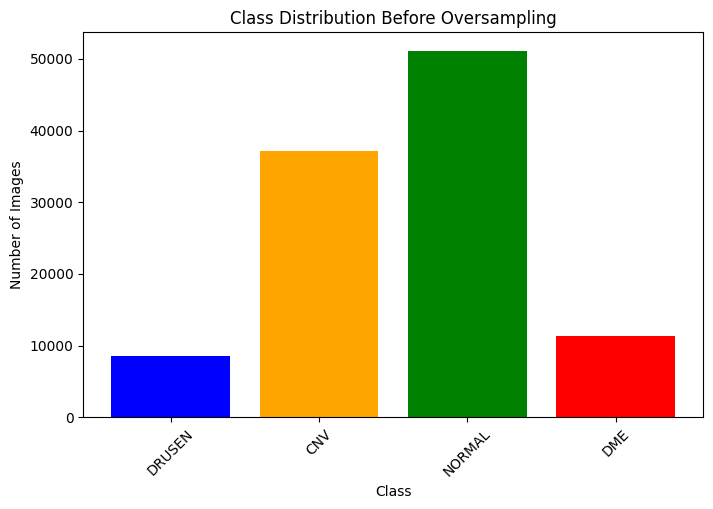

In [7]:
# -------------------------------
# Count Images in Each Class (Before Training)
# -------------------------------
import os 

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):  
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

dataset_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train"
class_counts_before = count_images_in_classes(dataset_path)

print("Class Distribution Before Oversampling:")
for class_name, count in class_counts_before.items():
    print(f"{class_name}: {count} images")

# Plot class distribution before oversampling
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.keys(), class_counts_before.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)
plt.show()

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the training set (76,000 images)
training_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Use the original dataset folder
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # The remaining images will go to validation
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Load the validation set (remaining images)
validation_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # Same split ratio
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Train dataset size:", training_set.cardinality().numpy() * 32)
print("Validation dataset size:", validation_set.cardinality().numpy() * 32)


Found 108309 files belonging to 4 classes.
Using 76000 files for training.
Found 108309 files belonging to 4 classes.
Using 32309 files for validation.
Train dataset size: 76000
Validation dataset size: 32320


In [9]:
INPUT_SHAPE=(224,224,3)

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

vgg16.trainable = False 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Add custom classification layers
x = GlobalAveragePooling2D()(vgg16.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(4, activation="softmax")(x)  # 4 classes (CNV, DME, DRUSEN, NORMAL)

In [10]:
# Create final model
model = Model(inputs=vgg16.input, outputs=x)

In [11]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=metrics_list)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
training_history=model.fit(x=training_set, validation_data=validation_set, epochs=7)

Epoch 1/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 507s 207ms/step - accuracy: 0.7631 - f1_score: 0.6111 - loss: 0.8013 - val_accuracy: 0.8935 - val_f1_score: 0.7914 - val_loss: 0.3050
Epoch 2/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.8832 - f1_score: 0.7823 - loss: 0.3336 - val_accuracy: 0.9061 - val_f1_score: 0.8096 - val_loss: 0.2719
Epoch 3/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.8977 - f1_score: 0.8103 - loss: 0.2902 - val_accuracy: 0.9112 - val_f1_score: 0.8238 - val_loss: 0.2577
Epoch 4/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9075 - f1_score: 0.8289 - loss: 0.2640 - val_accuracy: 0.9167 - val_f1_score: 0.8380 - val_loss: 0.2425
Epoch 5/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9147 - f1_score: 0.8414 - loss: 0.2420 - val_accuracy: 0.9180 - val_f1_score: 0.8461 - val_loss: 0.2375
Epoch 6/7
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9201 - f1_score: 0.8531 - loss: 0.2265 - val_accuracy:

In [15]:
model.save("vgg16_model.h5")
model.save("vgg16_model.keras")

In [16]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("vgg16_Training_history.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

In [17]:
from IPython.display import FileLink 
FileLink('vgg16_model.h5')

/kaggle/working/vgg16_model.h5

In [18]:
from IPython.display import FileLink 
FileLink('vgg16_model.keras')

/kaggle/working/vgg16_model.keras

In [19]:
training_history_1=model.fit(x=training_set, validation_data=validation_set, epochs=8)

Epoch 1/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 481s 203ms/step - accuracy: 0.9288 - f1_score: 0.8696 - loss: 0.2028 - val_accuracy: 0.9238 - val_f1_score: 0.8568 - val_loss: 0.2210
Epoch 2/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9321 - f1_score: 0.8761 - loss: 0.1939 - val_accuracy: 0.9266 - val_f1_score: 0.8617 - val_loss: 0.2183
Epoch 3/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 480s 202ms/step - accuracy: 0.9353 - f1_score: 0.8812 - loss: 0.1840 - val_accuracy: 0.9285 - val_f1_score: 0.8655 - val_loss: 0.2116
Epoch 4/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9384 - f1_score: 0.8882 - loss: 0.1773 - val_accuracy: 0.9277 - val_f1_score: 0.8643 - val_loss: 0.2135
Epoch 5/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9414 - f1_score: 0.8932 - loss: 0.1654 - val_accuracy: 0.9276 - val_f1_score: 0.8683 - val_loss: 0.2122
Epoch 6/8
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 482s 203ms/step - accuracy: 0.9442 - f1_score: 0.8986 - loss: 0.1598 - val_accuracy:

In [20]:
model.save("vgg16_model_1.h5")
model.save("vgg16_model_1.keras")

In [21]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("vgg16_Training_history_1.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

In [22]:
from IPython.display import FileLink 
FileLink('vgg16_model_1.h5')

/kaggle/working/vgg16_model_1.h5

In [1]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/vgg16/other/default/1/vgg16_model_1.h5")  # Load saved model

# **Model performance**

In [2]:
#REloading history from pickle file
import pickle
with open("/kaggle/input/vgg16-history/vgg16_Training_history_1.pkl", "rb") as f:
    load_history=pickle.load(f)
print(load_history)

{'accuracy': [0.8313684463500977, 0.8883816003799438, 0.9023157954216003, 0.9110131859779358, 0.9169868230819702, 0.9225921034812927, 0.926263153553009], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8619265 , 0.63916135, 0.3747702 , 0.9125106 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.90918994, 0.7774278 , 0.52783144, 0.9473238 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.920532 , 0.8142718, 0.5792683, 0.9541027], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.92846185, 0.8333763 , 0.6155999 , 0.9582973 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.93349206, 0.85101455, 0.6316083 , 0.9612298 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.93847084, 0.8610542 , 0.66347915, 0.9630556 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9417784 , 0.87107074, 0.67653507, 0.96450984], dtype=float32)>], 'loss': [0

In [3]:
load_history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss'])

# **Model Evaluation**

In [7]:
#pre-processing the test dataset
test_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1000 files belonging to 4 classes.


In [8]:
test_loss, test_acc, f1_score=model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 304ms/step - accuracy: 0.9125 - f1_score: 0.5742 - loss: 0.2307


In [9]:
test_loss, test_acc, f1_score

(0.3679961562156677,
 0.8569999933242798,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8410256 , 0.9278752 , 0.67546165, 0.93690246], dtype=float32)>)

In [12]:
true_categories=tf.concat([y for x, y in test_set], axis=0)
Y_true=tf.argmax(true_categories, axis=1)

In [13]:
#computing predicted labels using test_set
predicted_categories = model.predict(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step


In [14]:
Y_Pred=tf.argmax(predicted_categories, axis=1)
Y_Pred

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

# **Classification Report**

In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_Pred))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84       250
           1       0.90      0.95      0.93       250
           2       0.99      0.51      0.68       250
           3       0.90      0.98      0.94       250

    accuracy                           0.86      1000
   macro avg       0.88      0.86      0.85      1000
weighted avg       0.88      0.86      0.85      1000



# **Confusion Matrix**

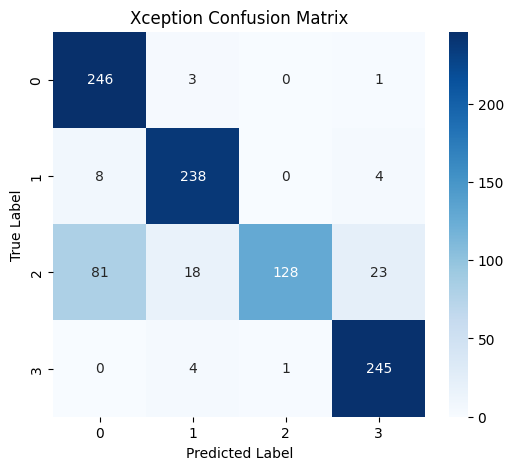

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm=confusion_matrix(Y_true, Y_Pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Xception Confusion Matrix", fontsize=12)
plt.show()

# **Single Prediction Code**

In [17]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import os

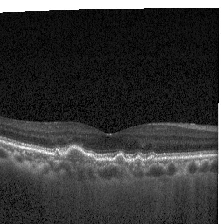

In [18]:
image_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test/DRUSEN/DRUSEN-11129-2.jpeg"
img = tf.keras.utils.load_img(image_path, target_size=(224,224))
img

In [19]:
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [20]:
x.shape

(1, 224, 224, 3)

In [21]:
pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [22]:
class_name=['CNV', 'DME', 'DRUSEN', 'NORMAL']
result_index = np.argmax(pred)
print("Model Prediction: ", class_name[result_index])

Model Prediction:  DRUSEN
